In [1]:
import datetime
import json
import os
import pathlib

import cv2
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, models
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tqdm import tqdm

2025-01-11 17:53:45.134113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736628826.224415  438187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736628826.520956  438187 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 17:53:49.459734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_path = pathlib.Path(os.getcwd(), "..", "..").resolve()

class Config:
    experiments_path = pathlib.Path(os.path.join(base_path, "experiments", "autoencoder")).resolve()
    dataset_path = pathlib.Path(os.path.join(base_path, "data", "categorized_images")).resolve()
    patience = 5
    epochs = 1000
    batch_size = 8
    encoding_dim = 128
    imgsz = 128
    n_clusters = 4

os.makedirs(Config.experiments_path, exist_ok=True)

In [3]:
print(Config.experiments_path)

/mnt/c/Users/Ricardo/Documents/Development/tcc-1/experiments/autoencoder


In [4]:
def build_autoencoder(input_shape, encoding_dim):
    inputs = tf.keras.Input(shape=input_shape, name="encoder_input")

    # Encoder
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(
        64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(
        128, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

    # Calculate shape before flattening
    shape_before_flattening = x.shape[1:]  # (H, W, C)
    flattened_dim = int(np.prod(shape_before_flattening))  # Convert to integer

    x = tf.keras.layers.Flatten()(x)
    encoded = tf.keras.layers.Dense(
        encoding_dim, activation="relu", name="latent")(x)

    # Decoder
    x_dec = tf.keras.layers.Dense(
        flattened_dim, activation="relu", name="dec_dense")(encoded)
    x_dec = tf.keras.layers.Reshape(shape_before_flattening)(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        128, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        64, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        32, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    decoded = tf.keras.layers.Conv2D(
        3, (3, 3), activation="sigmoid", padding="same")(x_dec)

    autoencoder = tf.keras.Model(inputs, decoded, name="autoencoder")
    encoder = tf.keras.Model(inputs, encoded, name="encoder")

    return autoencoder, encoder

In [5]:
# Build models
autoencoder, encoder = build_autoencoder(
    input_shape=(Config.imgsz, Config.imgsz, 3), encoding_dim=Config.encoding_dim
)

I0000 00:00:1736628871.307638  438187 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


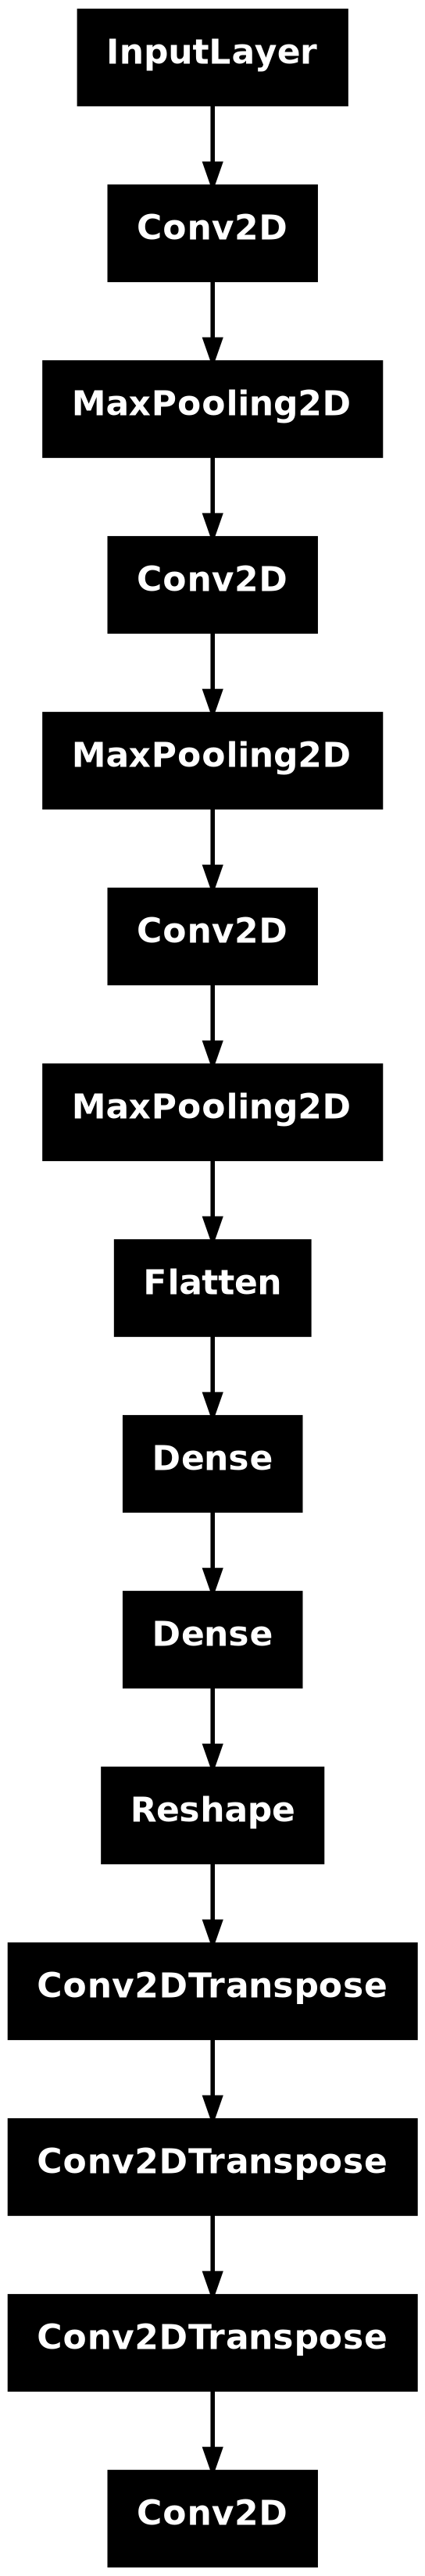

In [6]:
# Save autoencoder
autoencoder.save(os.path.join(Config.experiments_path, "autoencoder_no_train.keras"))
keras.utils.plot_model(autoencoder, os.path.join(Config.experiments_path, "autoencoder.png"), show_shapes=True)
keras.utils.plot_model(autoencoder, os.path.join(Config.experiments_path, "autoencoder_no_shapes.png"), show_shapes=False)

In [7]:
def perform_tsne_and_clustering(encoder, dataset, n_clusters, experiments_path):
    # Extract embeddings using encoder
    embeddings = []
    for images, _ in dataset.unbatch():
        embeddings.append(encoder.predict(images[np.newaxis, ...]))
    embeddings = np.concatenate(embeddings, axis=0)

    # Apply TSNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_embeddings)

    # Save embeddings and cluster labels
    np.save(os.path.join(experiments_path, "tsne_embeddings.npy"), tsne_embeddings)
    np.save(os.path.join(experiments_path, "cluster_labels.npy"), cluster_labels)

    # Plot t-SNE results
    plt.figure(figsize=(10, 8))
    for cluster in range(n_clusters):
        cluster_points = tsne_embeddings[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.6)
    plt.legend()
    plt.title("t-SNE Clustering")
    plt.savefig(os.path.join(experiments_path, "tsne_clustering.png"))
    plt.show()

    # Plot t-SNE results without clustering (just the points)
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], alpha=0.6)
    plt.title("t-SNE Points without Clustering")
    plt.savefig(os.path.join(experiments_path, "tsne_points.png"))
    plt.show()

    return tsne_embeddings, cluster_labels

In [8]:
# Construindo o modelo
autoencoder, encoder = build_autoencoder(
    (Config.imgsz, Config.imgsz, 3), Config.encoding_dim)
autoencoder.compile(optimizer="adam", loss="mse")

tuplify = lambda x, n: (x, ) * n
duplify = lambda x: tuplify(x, 2)

# Carregando o dataset
train_dataset = image_dataset_from_directory(
    Config.dataset_path,
    labels=None,
    image_size=(Config.imgsz, Config.imgsz),
    batch_size=Config.batch_size,
    shuffle=True
).map(lambda x: duplify(x / 255.0))

Found 5652 files.


In [9]:
# # Treinamento com EarlyStopping
# early_stopping = EarlyStopping(
#     monitor="loss",  # Monitora a métrica de perda
#     patience=Config.patience,
#     restore_best_weights=True  # Restaura os pesos da melhor época
# )

# steps_per_epoch = len(train_dataset) // Config.batch_size

# # Treinando o modelo
# autoencoder.fit(
#     train_dataset.repeat(),
#     epochs=Config.epochs,
#     steps_per_epoch=steps_per_epoch,
#     callbacks=[early_stopping]
# )

In [10]:
# # Extração de embeddings com progresso usando tqdm
# embeddings = []
# # Converte para iterador NumPy
# dataset_iterator = train_dataset.unbatch().as_numpy_iterator()
# total_images = len(list(train_dataset.unbatch()))  # Conta o total de imagens

# for image_pair in tqdm(dataset_iterator, total=total_images, desc="Extraindo Embeddings"):
#     image = image_pair[0]  # Extrai a imagem (primeiro elemento do par)
#     # Adiciona dimensão de batch
#     embeddings.append(encoder.predict(image[tf.newaxis, ...], verbose=0))

# embeddings = np.vstack(embeddings)

# # TSNE e visualização
# tsne = TSNE(n_components=2, random_state=42)
# tsne_embeddings = tsne.fit_transform(embeddings)

# # Visualizar t-SNE
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], alpha=0.5)
# plt.title("t-SNE Visualization of Embeddings (Large Category)")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.grid()
# plt.show()

# # Imprimindo os pontos do t-SNE
# print("t-SNE Points:")
# print(tsne_embeddings)

In [11]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.cluster import KMeans

# # Clusterização com K-Means
# n_clusters = 4  # Número de clusters desejado
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(tsne_embeddings)

# # Visualizar os clusters
# plt.figure(figsize=(10, 8))
# for cluster in range(n_clusters):
#     cluster_points = tsne_embeddings[cluster_labels == cluster]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
#                 label=f"Cluster {cluster}", alpha=0.6)

# # Marcar os centróides
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], s=200,
#             c="black", marker="X", label="Centroids")

# # Configurar o gráfico
# plt.title("t-SNE Clusters with K-Means")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.legend()
# plt.grid()
# plt.show()

# # Exibir as informações dos clusters
# for cluster in range(n_clusters):
#     print(f"Cluster {cluster}: {np.sum(cluster_labels == cluster)} points")

In [12]:
def show_cluster_examples(dataset, tsne_embeddings, cluster_labels, n_examples=5):
    """
    Mostra exemplos de imagens pertencentes a cada cluster.
    
    Args:
    - dataset: Dataset original usado para t-SNE (formato (input, input)).
    - tsne_embeddings: Embeddings do t-SNE (array de shape (N, 2)).
    - cluster_labels: Rótulos dos clusters gerados (array de shape (N,)).
    - n_examples: Número de exemplos para mostrar de cada cluster.
    """
    unique_clusters = np.unique(cluster_labels)
    # Convertendo o dataset para iterador NumPy
    dataset_iterator = dataset.unbatch().as_numpy_iterator()

    # Carregar todas as imagens para acesso rápido
    # Usar apenas as imagens de entrada
    all_images = [pair[0] for pair in dataset_iterator]
    all_images = np.array(all_images)

    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, min(
            n_examples, len(cluster_indices)), replace=False)

        # Mostrar exemplos do cluster
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Cluster {cluster}", fontsize=16)

        for i, idx in enumerate(selected_indices):
            plt.subplot(1, n_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.title(f"Point {idx}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

In [13]:
def extract_embeddings(dataset, encoder, subdataset_name):
    embeddings = []
    dataset_iterator = dataset.unbatch().as_numpy_iterator()
    total_images = sum(1 for _ in dataset_iterator)

    for image_pair in tqdm(dataset.unbatch(), total=total_images, desc=f"Extracting Embeddings for {subdataset_name}"):
        embeddings.append(encoder.predict(
            image_pair[0][tf.newaxis, ...], verbose=0))

    return np.vstack(embeddings)

In [14]:
def find_optimal_clusters(embeddings, max_clusters=10):
    from sklearn.metrics import silhouette_score

    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(score)

    optimal_clusters = np.argmax(silhouette_scores) + 2
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker="o")
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

    return optimal_clusters

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_tsne(embeddings, cluster_labels, subdataset_name):
    # Plot com os clusters
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(cluster_labels)
    for cluster in unique_labels:
        cluster_points = embeddings[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Grupo {
                    cluster}", alpha=0.6)
    plt.legend()
    plt.title(f"t-SNE e Clusters")
    plt.show()

    # Plot sem os clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6)
    plt.title(f"t-SNE")
    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    plt.show()

def visualize_tsne_3D(embeddings, cluster_labels, subdataset_name):
    # Plot com os clusters (3D)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(cluster_labels)
    for cluster in unique_labels:
        cluster_points = embeddings[cluster_labels == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                   label=f"Grupo {cluster}", alpha=0.6)
    ax.legend()
    ax.set_title(f"t-SNE e Clusters (3D)")
    ax.set_xlabel("Dimensão 1")
    ax.set_ylabel("Dimensão 2")
    ax.set_zlabel("Dimensão 3")
    plt.show()

    # Plot sem os clusters (3D)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], alpha=0.6)
    ax.set_title(f"t-SNE (3D)")
    ax.set_xlabel("Dimensão 1")
    ax.set_ylabel("Dimensão 2")
    ax.set_zlabel("Dimensão 3")
    plt.show()

In [16]:
def process_dataset(subdataset_path, subdataset_name):
    print(f"Processing subdataset: {subdataset_name}")

    # Carregar o dataset
    train_dataset = image_dataset_from_directory(
        subdataset_path,
        labels=None,
        image_size=(Config.imgsz, Config.imgsz),
        batch_size=Config.batch_size,
        shuffle=True
    ).map(lambda x: (x / 255.0, x / 255.0))

    # Construir e treinar o autoencoder
    autoencoder, encoder = build_autoencoder(
        (Config.imgsz, Config.imgsz, 3), Config.encoding_dim)
    autoencoder.compile(optimizer="adam", loss="mse")

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss", patience=Config.patience, restore_best_weights=True
    )
    autoencoder.fit(train_dataset.repeat(), epochs=Config.epochs,
                    steps_per_epoch=len(train_dataset) // Config.batch_size,
                    callbacks=[early_stopping], verbose=0)

    # Extrair embeddings
    embeddings = extract_embeddings(train_dataset, encoder, subdataset_name)

    # Encontrar número ótimo de clusters
    optimal_clusters = find_optimal_clusters(embeddings)
    print(f"Optimal number of clusters: {optimal_clusters}")

    use_3d = True

    # Clusterização e visualização
    tsne = TSNE(n_components=3 if use_3d else 2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_embeddings)

    if use_3d:
        visualize_tsne_3D(tsne_embeddings, cluster_labels, subdataset_name)
    else:
        visualize_tsne(tsne_embeddings, cluster_labels, subdataset_name)

In [17]:
import tensorflow as tf
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:

# Iterar sobre os subdatasets
subdatasets = [d for d in Config.dataset_path.iterdir() if d.is_dir()]


Processing subdataset: all
Found 3406 files.


I0000 00:00:1736628906.537861  438432 service.cc:148] XLA service 0x7f0ae4014430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736628906.538717  438432 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-01-11 17:55:09.642393: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736628910.155269  438432 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1736628918.972367  438432 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-01-11 17:55:31.834469: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Extracting Embeddings for all: 100%|██████████| 3406/3406 [04:03<00:00, 14.01it/s]


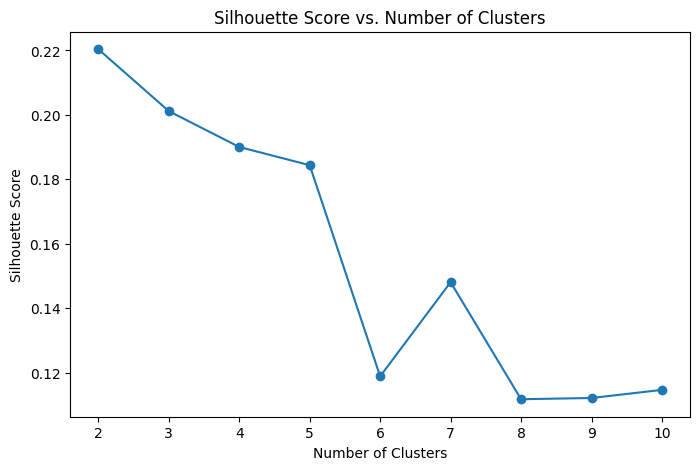

Optimal number of clusters: 2


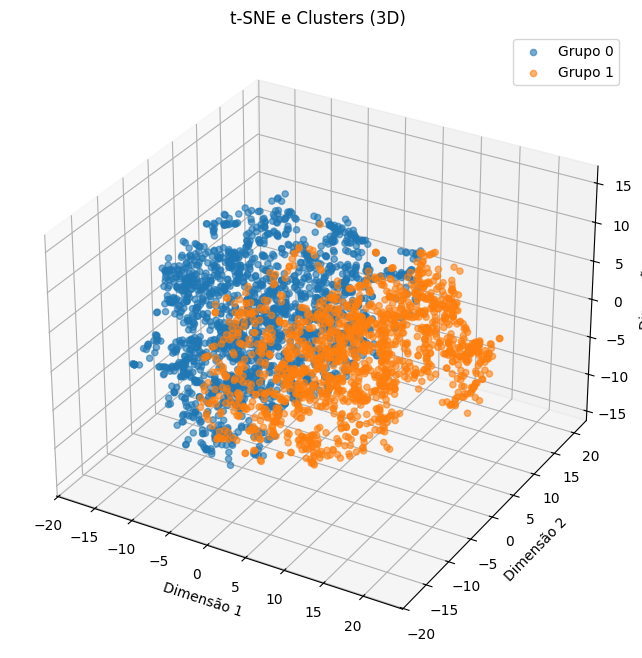

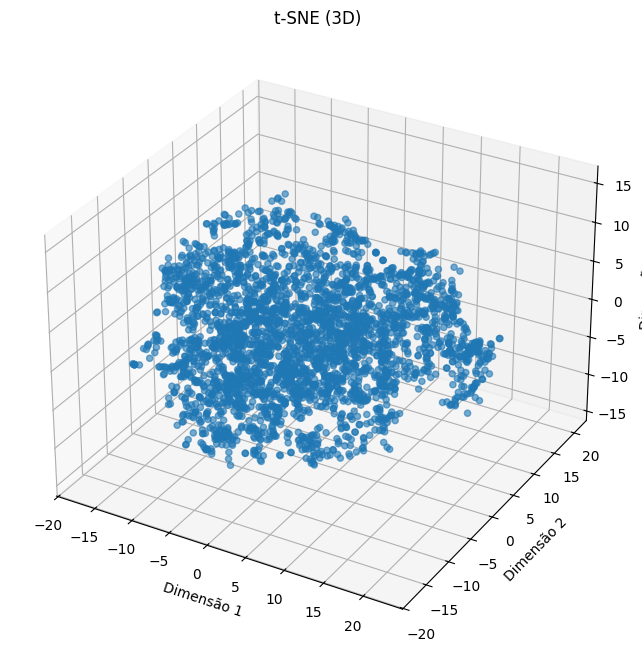

Processing subdataset: large
Found 956 files.


Extracting Embeddings for large: 100%|██████████| 956/956 [01:03<00:00, 15.13it/s]


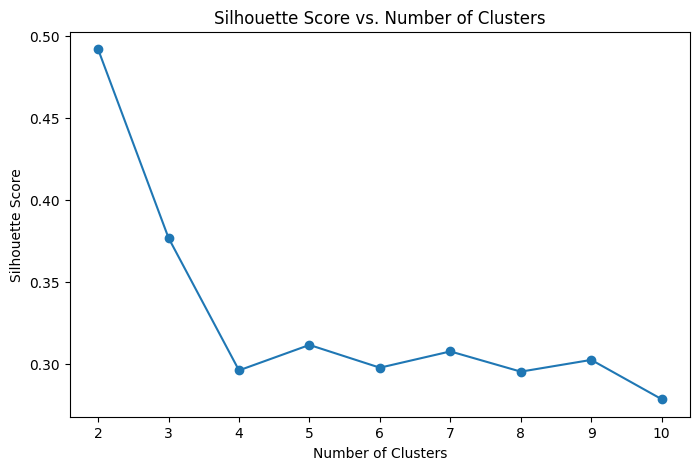

Optimal number of clusters: 2


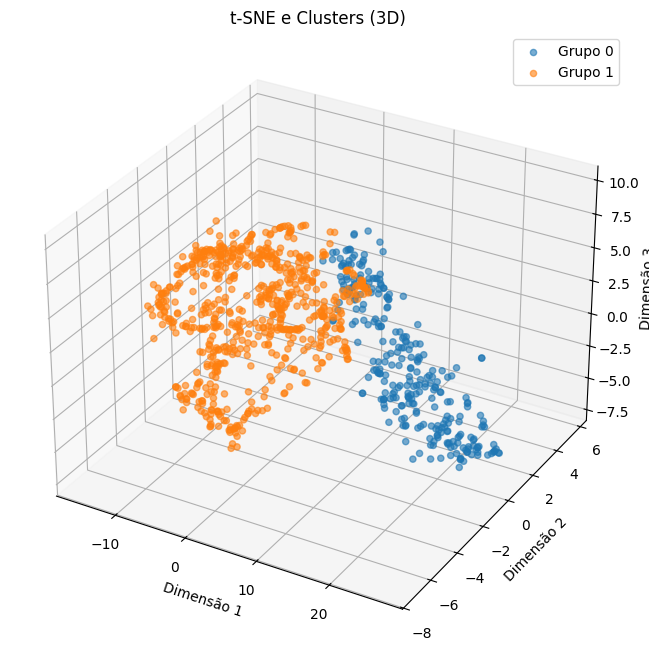

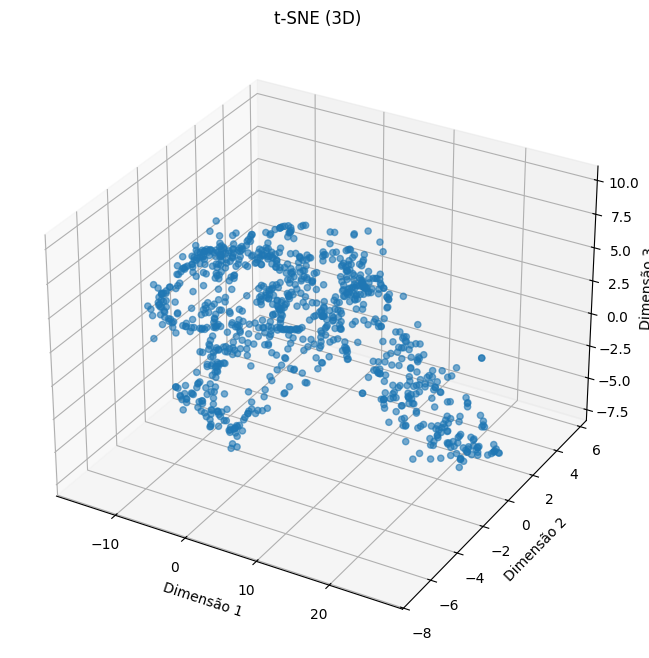

Processing subdataset: medium
Found 520 files.


Extracting Embeddings for medium: 100%|██████████| 520/520 [00:36<00:00, 14.17it/s]


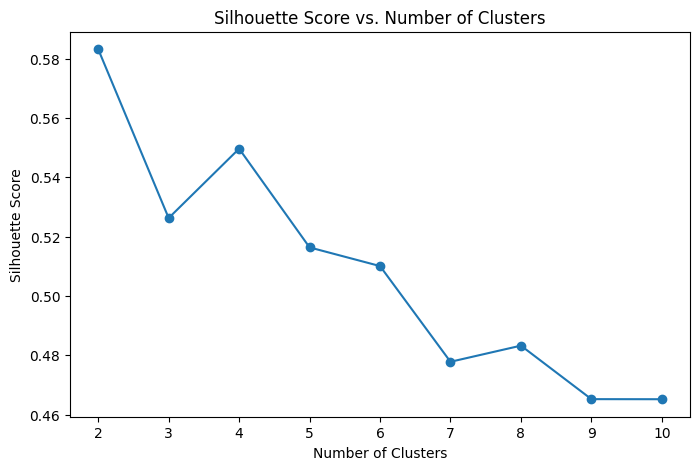

Optimal number of clusters: 2


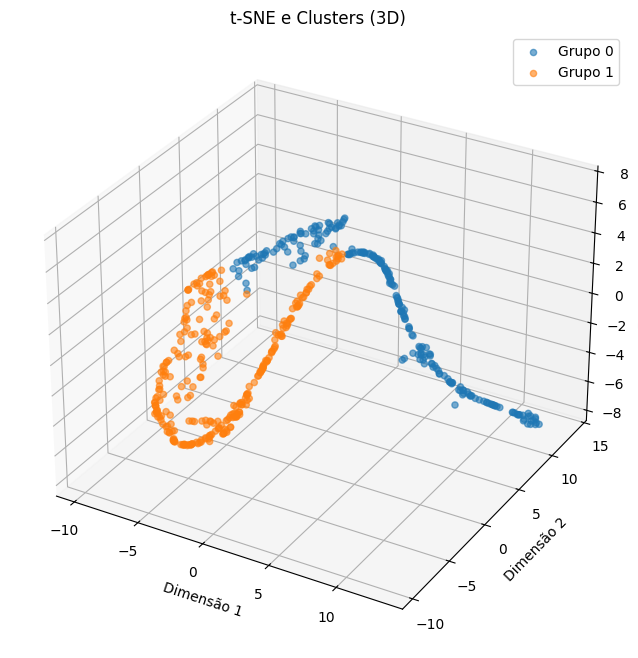

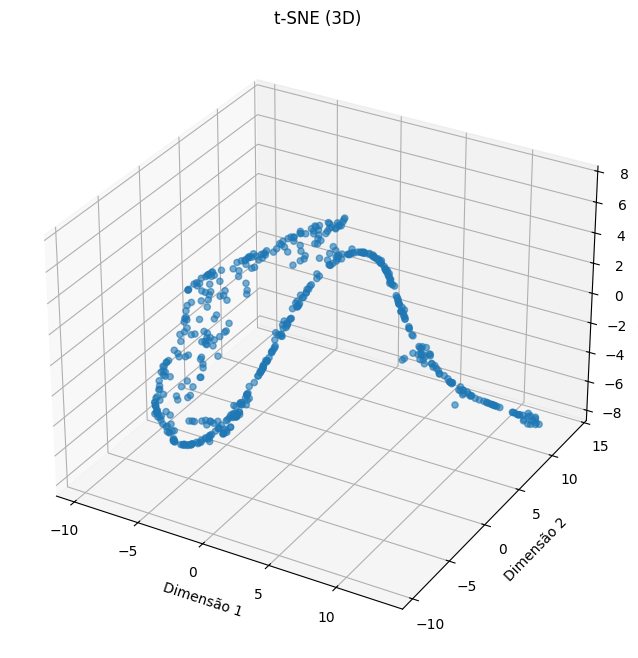

Processing subdataset: mini
Found 281 files.


Extracting Embeddings for mini: 100%|██████████| 281/281 [00:15<00:00, 17.82it/s]


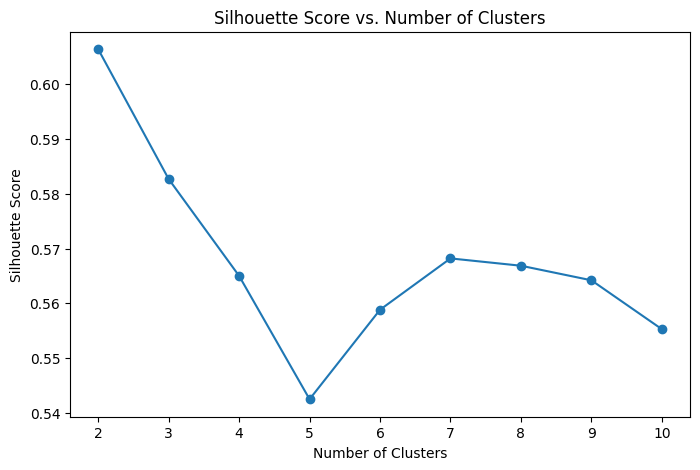

Optimal number of clusters: 2


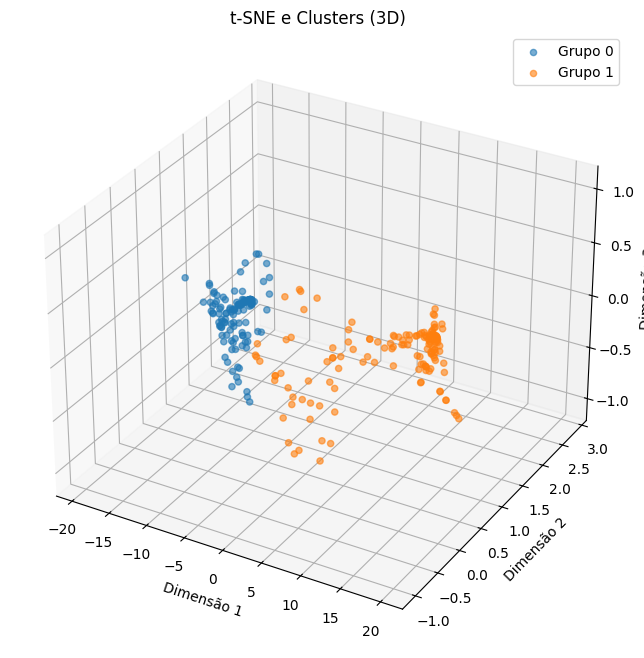

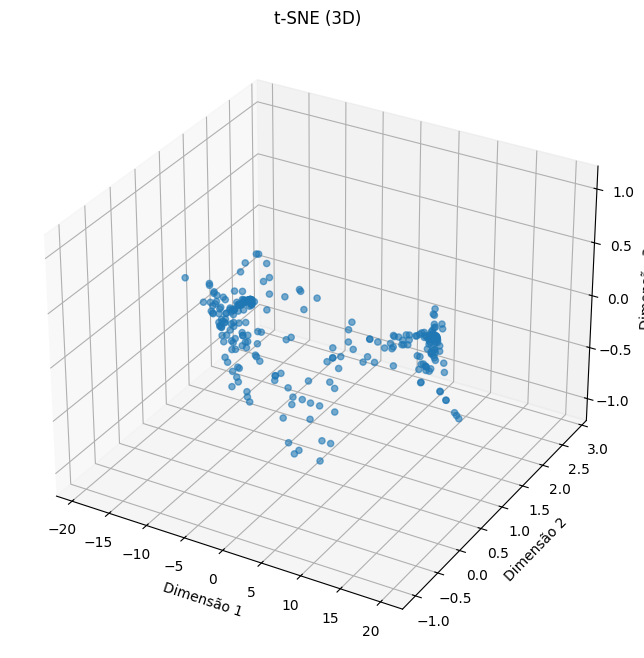

Processing subdataset: small
Found 489 files.


Extracting Embeddings for small: 100%|██████████| 489/489 [00:35<00:00, 13.90it/s]


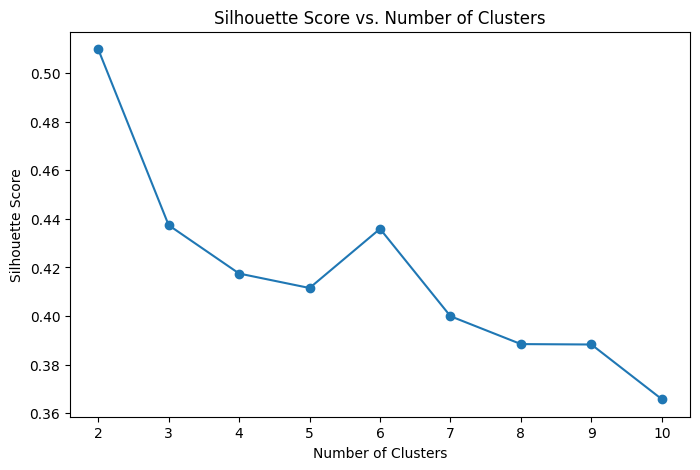

Optimal number of clusters: 2


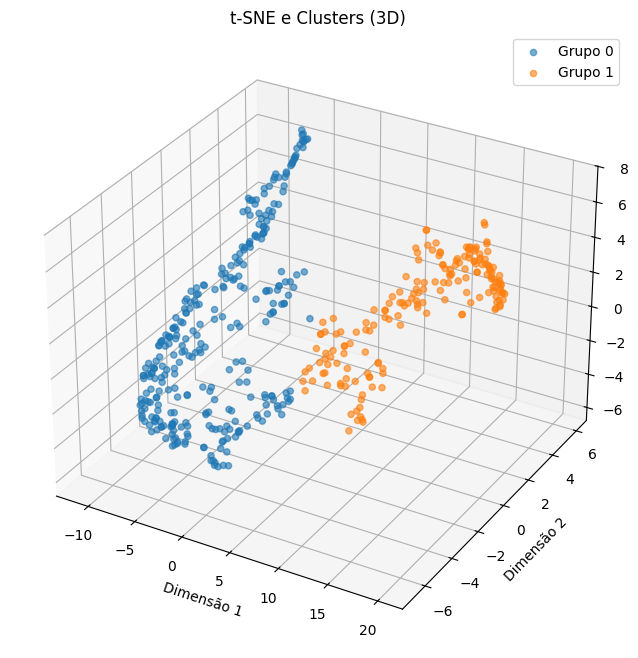

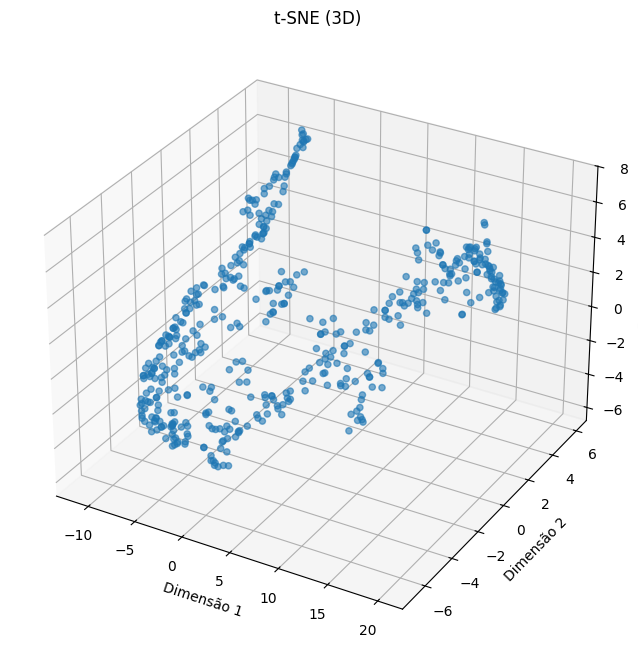

In [19]:
for subdataset in subdatasets:
    process_dataset(subdataset, subdataset.name)